In [ ]:
from google.colab import data_table
data_table.enable_dataframe_formatter()

In [ ]:
!lscpu |grep 'Model name'

Model name:          Intel(R) Xeon(R) CPU @ 2.20GHz


In [ ]:
!cat /proc/meminfo

MemTotal:       13297228 kB
MemFree:         2495964 kB
MemAvailable:    5816104 kB
Buffers:           76704 kB
Cached:          1565512 kB
SwapCached:            0 kB
Active:          1254932 kB
Inactive:        9312460 kB
Active(anon):     370224 kB
Inactive(anon):  6683084 kB
Active(file):     884708 kB
Inactive(file):  2629376 kB
Unevictable:           0 kB
Mlocked:               0 kB
SwapTotal:             0 kB
SwapFree:              0 kB
Dirty:               604 kB
Writeback:             0 kB
AnonPages:       8924908 kB
Mapped:           295324 kB
Shmem:              1164 kB
KReclaimable:      95012 kB
Slab:             125136 kB
SReclaimable:      95012 kB
SUnreclaim:        30124 kB
KernelStack:        4144 kB
PageTables:        54980 kB
NFS_Unstable:          0 kB
Bounce:                0 kB
WritebackTmp:          0 kB
CommitLimit:     6648612 kB
Committed_AS:   10308696 kB
VmallocTotal:   34359738367 kB
VmallocUsed:        8888 kB
VmallocChunk:          0 kB
Percpu:          

In [ ]:
import pandas as pd
import numpy as np
import re

import nltk
from nltk.corpus import words
from nltk.corpus import stopwords
from textblob import Word, TextBlob

import matplotlib.pyplot as plt
from wordcloud import WordCloud

from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.preprocessing import LabelEncoder

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import KFold


from sklearn.model_selection import GridSearchCV, train_test_split,cross_val_score
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,ConfusionMatrixDisplay

from nltk.tokenize import word_tokenize

from nltk.stem import WordNetLemmatizer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier



nltk.download('stopwords')
nltk.download('words')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [ ]:
df = pd.read_csv("youtube_data_comments.csv")
df.isnull().sum()

results    1
dtype: int64

In [ ]:
len(df)

10541

In [ ]:
df = df.dropna()

In [ ]:
len(df)

10540

In [ ]:
def remove_links(df,col):
  regex_links = "http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+"
  df[col] = df[col].str.replace(regex_links, '',regex=True)
  return df

def remove_non_letter_numbers(df,col):
  regex_non_letter_num = "[^a-zA-Z]"
  df[col] = df[col].str.replace(regex_non_letter_num, ' ',regex=True)

  return df


def remove_emojis(df,col):
  emoji_pattern = re.compile("["
  u"\U0001F600-\U0001F64F"  # emoticons
  u"\U0001F300-\U0001F5FF"  # symbols & pictographs
  u"\U0001F680-\U0001F6FF"  # transport & map symbols
  u"\U0001F1E0-\U0001F1FF"  # flags
                        "]+", flags=re.UNICODE)
  
  df[col] = df[col].str.replace(emoji_pattern, '',regex=True)

  return df


def decontracted(df, column):
    replacements = [
        ("won't", "will not"),
        ("can't", "can not"),
        ("shan't", "shall not"),
        ("ain't", "am not"),
        ("aren't", "are not"),
        ("isn't", "is not"),
        ("wasn't", "was not"),
        ("weren't", "were not"),
        ("haven't", "have not"),
        ("hasn't", "has not"),
        ("hadn't", "had not"),
        ("don't", "do not"),
        ("doesn't", "does not"),
        ("didn't", "did not"),
        ("mightn't", "might not"),
        ("mustn't", "must not"),
        ("needn't", "need not"),
        ("shouldn't", "should not"),
        ("wouldn't", "would not"),
        ("n't", " not"),
        ("'re", " are"),
        ("'s", " is"),
        ("'d", " would"),
        ("'ll", " will"),
        ("'t", " not"),
        ("'ve", " have"),
        ("'m", " am")
    ]
    
    def expand(phrase):
        for contraction, expansion in replacements:
            phrase = re.sub(contraction, expansion, phrase)
        return phrase
    
    df[column] = df[column].map(expand)
    return df


def lowercase_text(df,col):
  df[col] = df[col].map(lambda x: x.lower())

  return df

def remove_stopwords(df,col):
  sw = stopwords.words('english')
  df[col] = df[col].apply(lambda x: " ".join(x for x in str(x).split() if x not in sw))

  return df


def rare_words(df,col):
  temp_df = pd.Series(' '.join(df[col]).split()).value_counts()
  drops = temp_df[temp_df <= 1]
  df[col] = df[col].apply(lambda x: " ".join(x for x in x.split() if x not in drops))

  return df


lemmatizer = WordNetLemmatizer()
vader = SentimentIntensityAnalyzer()
def classify_sentiment(text):
    tokens = word_tokenize(text)

    lemmas = [lemmatizer.lemmatize(token) for token in tokens]

    # Analyze the sentiment
    sentiment = vader.polarity_scores(" ".join(lemmas))

    # Classify the sentiment as positive or negative
    if sentiment['compound'] > 0:
        return 'positive'
    else:
        return 'negative'


In [ ]:
df = remove_links(df,"results")
df = lowercase_text(df,"results")
df = decontracted(df,"results")
df = remove_emojis(df,"results")
df = remove_non_letter_numbers(df,"results")
df = remove_stopwords(df,"results")
df["clean_text"] = rare_words(df,"results")

In [ ]:
df

,results,clean_text
0,carbon footprint wren first people sign kurzge...,carbon footprint wren first people sign kurzge...
1,sitting outside high school library hanging fr...,sitting outside high school library hanging fr...
2,ants like warhammer k one ones still fighting,ants like warhammer k one ones still fighting
3,legit afraid go backyard old resident take car...,legit afraid go backyard old resident take car...
4,love ants saga btw english teacher spain alway...,love ants saga btw english teacher spain alway...
...,...,...
10536,sad come back read pre release comments full e...,sad come back read pre release comments full e...
10537,edit spoilers ahead dlc coming cyberpunk want ...,edit spoilers ahead dlc coming cyberpunk want ...
10538,year economic crisis nuclear crisis sounds lot...,year economic crisis nuclear crisis sounds lot...
10539,would thought budget went keanu left actual ga...,would thought budget went keanu left actual ga...


In [ ]:
df["sentiment"] = df.clean_text.apply(classify_sentiment)

In [ ]:
df["sentiment"] = LabelEncoder().fit_transform(df["sentiment"])

In [ ]:
df["sentiment"].value_counts()

1    6794
0    3746
Name: sentiment, dtype: int64

In [ ]:
df.columns

Index(['results', 'clean_text', 'sentiment'], dtype='object')

In [ ]:
# df.to_csv("youtube_data_labeled.csv",index=False,encoding="utf-8")

In [ ]:
df.clean_text

0        carbon footprint wren first people sign kurzge...
1        sitting outside high school library hanging fr...
2            ants like warhammer k one ones still fighting
3        legit afraid go backyard old resident take car...
4        love ants saga btw english teacher spain alway...
                               ...                        
10536    sad come back read pre release comments full e...
10537    edit spoilers ahead dlc coming cyberpunk want ...
10538    year economic crisis nuclear crisis sounds lot...
10539    would thought budget went keanu left actual ga...
10540                                release back overkill
Name: clean_text, Length: 10540, dtype: object

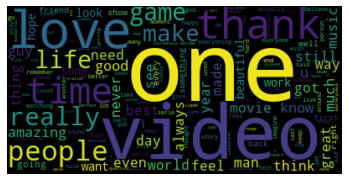

In [ ]:
text = " ".join(i for i in df.clean_text)

wordcloud = WordCloud().generate(text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [ ]:
models = [
    ('Logistic Regression', LogisticRegression()),
    ('Random Forest', RandomForestClassifier()),
    ('Naive Bayes', MultinomialNB()),
    ('Decision Tree', DecisionTreeClassifier())
]

In [ ]:
df.columns

Index(['results', 'clean_text', 'sentiment'], dtype='object')

In [ ]:
X = df['clean_text'].values
y = df['sentiment'].values

In [ ]:
vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(X)
X_tfidf_array = X_tfidf.toarray()

In [ ]:
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

Logistic Regression: accuracy mean 0.8689 
Logistic Regression: precision mean 0.8631
Logistic Regression: recall mean 0.8468
Logistic Regression: f1_score mean 0.8536
Random Forest: accuracy mean 0.8630 
Random Forest: precision mean 0.8565
Random Forest: recall mean 0.8402
Random Forest: f1_score mean 0.8470
Naive Bayes: accuracy mean 0.7419 
Naive Bayes: precision mean 0.7949
Naive Bayes: recall mean 0.6484
Naive Bayes: f1_score mean 0.6505
Decision Tree: accuracy mean 0.8587 
Decision Tree: precision mean 0.8476
Decision Tree: recall mean 0.8416
Decision Tree: f1_score mean 0.8443


<Figure size 432x288 with 0 Axes>

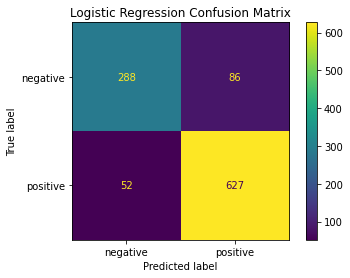

<Figure size 432x288 with 0 Axes>

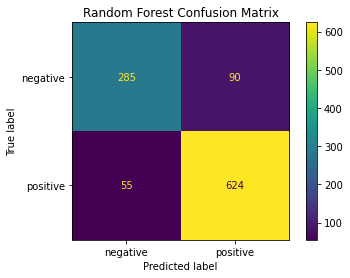

<Figure size 432x288 with 0 Axes>

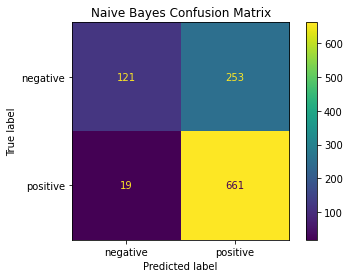

<Figure size 432x288 with 0 Axes>

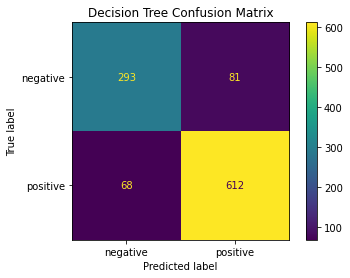

In [ ]:
# Loop through the machine learning models
for name, model in models:
    # Initialize lists to store the scores and confusion matrices for each fold
    scores = []
    cms = []
    precisions = []
    recalls = []
    f1_scores = []

    # Loop through the folds
    for train_index, test_index in kfold.split(X_tfidf_array):
        # Split the data into training and test sets
        X_train, X_test = X_tfidf_array[train_index], X_tfidf_array[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)

        cm = confusion_matrix(y_test, y_pred)

        # Calculate the precision, recall, and F1-score
        cr = classification_report(y_test, y_pred, output_dict=True)
        precisions.append(cr['0']['precision'])
        precisions.append(cr['1']['precision'])
        recalls.append(cr['0']['recall'])
        recalls.append(cr['1']['recall'])
        f1_scores.append(cr['0']['f1-score'])
        f1_scores.append(cr['1']['f1-score'])

        # Calculate the accuracy score
        score = accuracy_score(y_test, y_pred)

        # Store the score and confusion matrix for this fold
        scores.append(score)
        cms.append(cm)

    # Calculate the mean of the scores
    mean_score = np.mean(scores)
    mean_precision = np.mean(precisions)
    mean_recall = np.mean(recalls)
    mean_f1_score = np.mean(f1_scores)

    # Calculate the mean confusion matrix
    mean_cm = np.mean(cms, axis=0)
    mean_cm = np.round(mean_cm).astype(int)


    # Create a ConfusionMatrixDisplay object to visualize the confusion matrix
    cm_display = ConfusionMatrixDisplay(confusion_matrix=mean_cm, display_labels = ['negative', 'positive'])

    # Visualize the confusion matrix
    plt.figure()
    cm_display.plot()
    plt.title(f'{name} Confusion Matrix')


    #acc
    print(f'{name}: accuracy mean {mean_score:.4f} ')
    #mean_precision
    print(f'{name}: precision mean {mean_precision:.4f}')
    #mean_recall
    print(f'{name}: recall mean {mean_recall:.4f}')
    #mean_f1_score
    print(f'{name}: f1_score mean {mean_f1_score:.4f}')
